In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import ROOT

Welcome to JupyROOT 6.30/04


In [2]:
eta_flag="eta_greater_1"
#eta_flag="eta_lesser_1"
#eta_flag="eta_inclusive"

#flag = "Roch_corr"
#flag_str = "with Roch corr"

flag = "noRoch_corr"
flag_str = "without Roch corr"

In [3]:
input_path_1 = "/eos/home-n/nrawal/HZZ_Run3/HZZ_20UL18/simmed_files/skimmed_final/"
input_path_2 = "/eos/user/c/caruta/HZZ_SkimmedNtuples/"
Z_file = input_path_2+"DYJetsToLL_M-50_amcatnloFXFX_2018_skimmed_Roch-noRoch_merged_new.root"
if(flag=="Roch_corr"):
    Higgs_file = input_path_1+ "GluGlu_VBF_HToZZTo4L_M125_RunIISummer20UL18MiniAODv2_Roch.root"
    output_path_dir = f"output_plots_2l_Roch/{eta_flag}/"
    output_file_path = f"histogram_ratio_Z_2l_{eta_flag}_Roch.root"    
elif(flag=="noRoch_corr") :
    Higgs_file = input_path_1+ "GluGlu_VBF_HToZZTo4L_M125_RunIISummer20UL18MiniAODv2_noRoch.root"
    output_path_dir = f"output_plots_2l_noRoch/{eta_flag}/"
    output_file_path = f"histogram_ratio_Z_2l_{eta_flag}_noRoch.root"  


In [4]:
def read_root_file(file_path, branches):
    with uproot.open(file_path) as file:
        tree = file["passedEvents"]
        data = tree.arrays(branches, library="np")
    return data

In [5]:
def read_root_file_2(file_path, branches):
    with uproot.open(file_path) as file:
        tree = file["passedEvents"]
        data = tree.arrays(branches, library="np", entry_start = 1 , entry_stop = 500000)
        #data = tree.arrays(branches, library="np")
    return data

In [6]:
def apply_mass_cut_H_4l(data):
    mask = (data["pT1"] > 5 ) & (data["pT2"] > 5 ) & (data["pT3"] > 5 ) & (data["pT4"] > 5) & (abs(data["eta1"]) < 2.4) & (abs(data["eta2"]) < 2.4) & (abs(data["eta3"]) < 2.4) & (abs(data["eta4"]) < 2.4)  
    return {key: val[mask] for key, val in data.items()}

In [7]:
def apply_mass_cut_Z_2l(data, mass_var, mass_range):
    mask1 = (data["pT1"] > 5 ) & (data["pT2"] > 5 )  & (abs(data["eta1"]) < 2.4) & (abs(data["eta2"]) < 2.4) 
    mask2 = (data[mass_var] >= mass_range[0]) & (data[mass_var] <= mass_range[1])
    mask = mask1 & mask2
    return {key: val[mask] for key, val in data.items()}

In [8]:
def create_histogram(data, bins, range):
    histogram, bin_edges = np.histogram(data, bins=bins, range=range)
    return histogram, bin_edges

In [9]:
def plot_histogram(histogram, bin_edges, output_path):
    plt.figure(figsize=(10,10))
    plt.hist(bin_edges[:-1], bin_edges, weights=histogram)
    #plt.title(title)
    plt.savefig(output_path_dir+output_path)
    plt.close()

In [10]:
def normalize_histogram(histogram, bin_edges):
    bin_widths = np.diff(bin_edges)
    total_area = np.sum(histogram * bin_widths)
    normalized_histogram = histogram / total_area
    return normalized_histogram

def plot_normalized_histograms(hist1, bin_edges1, hist2, bin_edges2, title, xlabel, ylabel, output_path):

    normalized_hist1 = normalize_histogram(hist1, bin_edges1)
    normalized_hist2 = normalize_histogram(hist2, bin_edges2)

    bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2
    bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2

    plt.figure()
    plt.plot(bin_centers1, normalized_hist1, label="Histogram 1", linestyle='-', marker='o')
    plt.plot(bin_centers2, normalized_hist2, label="Histogram 2", linestyle='-', marker='x')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(output_path_dir+output_path)
    plt.close()
    
   

In [11]:
def numpy_to_th1d(histogram, bin_edges, name="hist", title="name"):
    th1d = ROOT.TH1D(name, title, len(bin_edges) - 1, bin_edges)
    for i in range(len(histogram)):
        th1d.SetBinContent(i + 1, histogram[i])
    return th1d

In [12]:
def plot_th1d_hist(hist1, hist2, title, output_path):
    hist1.Scale(1./hist1.Integral());
    hist2.Scale(1./hist2.Integral());
    c = ROOT.TCanvas()
    c.cd()
    c.SetTitle(title)
    hist1.Draw()
    hist1.SetLineColor(2)
    hist1.SetTitle(title)
    hist1.GetYaxis().SetTitle("Normalised Entries")
    hist2.SetLineColor(4)
    hist2.Draw("same")

    # Add a legend
    legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
    legend.AddEntry(hist1, "Higgs", "l")
    legend.AddEntry(hist2, "Z", "l")
    legend.Draw()

    # Draw the stat boxes for both histograms
    ROOT.gStyle.SetOptStat(111112211)
    hist1.SetStats(1)
    hist2.SetStats(1)

    # Adjust the positions of the stat boxes
    stat1 = hist1.GetListOfFunctions().FindObject("stats")
    stat1.SetX1NDC(0.11)
    stat1.SetX2NDC(0.35)
    stat1.SetY1NDC(0.75)
    stat1.SetY2NDC(0.9)

    stat2 = hist2.GetListOfFunctions().FindObject("stats")
    stat2.SetX1NDC(0.11)
    stat2.SetX2NDC(0.35)
    stat2.SetY1NDC(0.6)
    stat2.SetY2NDC(0.75)

    c.Update()
    c.SaveAs(output_path_dir+output_path)
#def plot_hist_root_style(hist, title, xlabel, ylabel, output_path):
def plot_hist_root_style(hist, output_path):
    c = ROOT.TCanvas()
    c.cd()
    ROOT.gStyle.SetOptStat(111112211)
    hist.Draw()
    #hist.SetTitle(title)
    #hist.GetXaxis().SetTitle(xlabel)
    #hist.GetYaxis().SetTitle(ylabel)
    #hist.SetLineColor(2)
    c.SaveAs(output_path_dir+output_path)
    
def  plot_normalised_hist_root_style(hist, output_path):
    c = ROOT.TCanvas()
    c.cd()
    ROOT.gStyle.SetOptStat(111112211)
    hist.Scale(1./hist.Integral())
    hist.GetYaxis().SetTitle("Normalised Entries")
    hist.Draw()
    #hist.SetLineColor(2)
    c.SaveAs(output_path_dir+output_path)

In [13]:
def reconstruct_m4l(pT1, pT2, pT3, pT4, eta1, eta2, eta3, eta4, phi1, phi2, phi3, phi4):
    mass_mu = 0.105658
    v1 = ROOT.TLorentzVector()
    v2 = ROOT.TLorentzVector()
    v3 = ROOT.TLorentzVector()
    v4 = ROOT.TLorentzVector()
    v1.SetPtEtaPhiM(pT1, eta1, phi1, mass_mu)
    v2.SetPtEtaPhiM(pT2, eta2, phi2, mass_mu)
    v3.SetPtEtaPhiM(pT3, eta3, phi3, mass_mu)
    v4.SetPtEtaPhiM(pT4, eta4, phi4, mass_mu)
    higgs = v1 + v2 + v3 + v4
    return higgs.M()

In [14]:
def reconstruct_m2l(pT1_noRoch, pT2_noRoch, eta1_noRoch, eta2_noRoch, phi1_noRoch, phi2_noRoch):
    mass_mu = 0.105658
    z_mass = ROOT.TLorentzVector()
    v1 = ROOT.TLorentzVector()
    v2 = ROOT.TLorentzVector()

    v1.SetPtEtaPhiM(pT1_noRoch, eta1_noRoch, phi1_noRoch, mass_mu)
    v2.SetPtEtaPhiM(pT2_noRoch, eta2_noRoch, phi2_noRoch, mass_mu)

    #print(" v1 ", v1.pT())
    z_mass = v1 + v2
    return z_mass.M()

In [15]:
def scale_pt_and_recalculate_mass_2l_noRoch(data, scale_factor):
    """
    Scale the pT values for muons with eta in the range [1.85, 2.4] and recalculate massH.
    """
    scaled_massZ = []
    for i in range(len(data["pT1_noRoch"])):
        pT1, pT2 = data["pT1_noRoch"][i], data["pT2_noRoch"][i]
        eta1, eta2 = data["eta1_noRoch"][i], data["eta2_noRoch"][i]
        phi1, phi2 = data["phi1_noRoch"][i], data["phi2_noRoch"][i]
        
        if(eta_flag=="eta_greater_1"):
            #print(" running eta greater 1")
            if 1 <= abs(eta1):
                pT1 *= (1 + scale_factor)         
            if 1 <= abs(eta2):
                pT2 *= (1 + scale_factor)
        elif(eta_flag=="eta_lesser_1"):
            #print(" running eta lesser 1")
            if abs(eta1) <=1:
                pT1 *= (1 + scale_factor)         
            if abs(eta2) <=1:
                pT2 *= (1 + scale_factor)
        elif (eta_flag=="eta_inclusive"):
            #print(" running eta inclusive")
            pT1 *= (1 + scale_factor)
            pT2 *= (1 + scale_factor)
        mass = reconstruct_m2l(pT1, pT2,  eta1, eta2,phi1, phi2)
        #print(" mass: ", mass)
        scaled_massZ.append(mass)
    scale_return = np.array(scaled_massZ)
    return scale_return

In [16]:
def scale_pt_and_recalculate_mass_2l_Roch(data, scale_factor):
    """
    Scale the pT values for muons with eta in the range [1.85, 2.4] and recalculate massH.
    """
    scaled_massZ = []
    for i in range(len(data["pT1"])):
        pT1, pT2 = data["pT1"][i], data["pT2"][i]
        eta1, eta2 = data["eta1"][i], data["eta2"][i]
        phi1, phi2 = data["phi1"][i], data["phi2"][i]
        
        if(eta_flag=="eta_greater_1"):
            #print(" running eta greater 1")
            if 1 <= abs(eta1):
                pT1 *= (1 + scale_factor)         
            if 1 <= abs(eta2):
                pT2 *= (1 + scale_factor)
        elif(eta_flag=="eta_lesser_1"):
            #print(" running eta lesser 1")
            if abs(eta1) <=1:
                pT1 *= (1 + scale_factor)         
            if abs(eta2) <=1:
                pT2 *= (1 + scale_factor)
        elif (eta_flag=="eta_inclusive"):
            #print(" running eta inclusive")
            pT1 *= (1 + scale_factor)
            pT2 *= (1 + scale_factor)
        mass = reconstruct_m2l(pT1, pT2,  eta1, eta2,phi1, phi2)
        #print(" mass: ", mass)
        scaled_massZ.append(mass)
    scale_return = np.array(scaled_massZ)
    return scale_return

In [17]:
def scale_pt_and_recalculate_mass_4l(data, scale_factor):
    """
    Scale the pT values for muons with eta in the range [1.85, 2.4] and recalculate massH.
    """
    scaled_massZ = []
    for i in range(len(data["pT1"])):
        pT1, pT2 , pT3, pT4= data["pT1"][i], data["pT2"][i], data["pT3"][i], data["pT4"][i]
        eta1, eta2 ,eta3, eta4= data["eta1"][i], data["eta2"][i], data["eta3"][i], data["eta4"][i]
        phi1, phi2, phi3, phi4 = data["phi1"][i], data["phi2"][i], data["phi3"][i], data["phi4"][i]
        
        if(eta_flag=="eta_greater_1"):
            #print(" running eta greater 1")
            if 1 <= abs(eta1):
                pT1 *= (1 + scale_factor)         
            if 1 <= abs(eta2):
                pT2 *= (1 + scale_factor)
            if 1 <= abs(eta3):
                pT3 *= (1 + scale_factor)         
            if 1 <= abs(eta4):
                pT4 *= (1 + scale_factor)
        elif(eta_flag=="eta_lesser_1"):

            if abs(eta1) <=1:
                pT1 *= (1 + scale_factor)         
            if abs(eta2) <=1:
                pT2 *= (1 + scale_factor)
            if abs(eta3) <=1:
                pT3 *= (1 + scale_factor)         
            if abs(eta4) <=1:
                pT4 *= (1 + scale_factor)
        elif (eta_flag=="eta_inclusive"):

            pT1 *= (1 + scale_factor)
            pT2 *= (1 + scale_factor)
            pT3 *= (1 + scale_factor)
            pT4 *= (1 + scale_factor)
        mass = reconstruct_m4l(pT1, pT2,  pT3, pT4, eta1, eta2, eta3, eta4, phi1, phi2, phi3, phi4)
        #print(" mass: ", mass)
        scaled_massZ.append(mass)
    scale_return = np.array(scaled_massZ)
    return scale_return

In [18]:
output_file = ROOT.TFile.Open(output_file_path, "RECREATE")
output_file.cd()
file1_path = Higgs_file
file2_path = Z_file
branches1 = ["pT1", "pT2", "pT3", "pT4", "eta1", "eta2", "eta3", "eta4", "phi1", "phi2", "phi3", "phi4", "massH", "GENmass4l", "pT1_genFromReco", "pT2_genFromReco","pT3_genFromReco","pT4_genFromReco",
            "genLep_eta1", "genLep_eta2", "genLep_eta3", "genLep_eta4",
            "genLep_phi1", "genLep_phi2", "genLep_phi3", "genLep_phi4", "massH"]
branches2 = ["pT1", "pT2", "eta1", "eta2", "phi1" , "phi2", "pT1_noRoch", "pT2_noRoch", "eta1_noRoch", "eta2_noRoch", "phi1_noRoch", "phi2_noRoch", "massZ","massZ_noRoch", "GENmass2l", "genzm"]
data1 = read_root_file(file1_path, branches1)
data2 = read_root_file_2(file2_path, branches2)

In [19]:
bins_normal = 100
bins=100
bins_mass = 1000
pT_range = (0, 200)
eta_range = (-2.5, 2.5)
phi_range = (-np.pi, np.pi)
mass_range_file1 = (110, 130)
mass_gen_range_file1 = (124.95, 125.05)
mass_range_file2 = (70, 110)
mass_gen_range_file2 = (70,110)

histograms = {}
bin_edges = {}

In [20]:
data1 = apply_mass_cut_H_4l(data1)
data2 = apply_mass_cut_Z_2l(data2, "massZ", mass_range_file2)

In [21]:
#variables1 = ["pT1", "pT2", "pT3", "pT4", "eta1", "eta2", "eta3", "eta4", "phi1", "phi2", "phi3", "phi4", "massH", "GENmass4l"]
variables1 = ["pT1", "pT2", "eta1", "eta2", "phi1", "phi2", "massH", "GENmass4l"]
if(flag=="Roch_corr"):
    variables2 = ["pT1", "pT2", "eta1", "eta2", "phi1", "phi2", "massZ"]
elif(flag=="noRoch_corr"):
    variables2 = ["pT1_noRoch", "pT2_noRoch", "eta1_noRoch", "eta2_noRoch", "phi1_noRoch", "phi2_noRoch", "massZ_noRoch"]
scale_factors = [0,0.0003, 0.001, 0.003,0.01]
scale_factor_strings = ["0", "0.03", "0.1", "0.3", "1"]

In [22]:
for i in range(len(variables1)): 
    print(variables1[i])

pT1
pT2
eta1
eta2
phi1
phi2
massH
GENmass4l


Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/pT1_Z.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/pT2_Z.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/eta1_Z.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/eta2_Z.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/phi1_Z.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/phi2_Z.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/massZ_Z.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/pT1_noRoch_Z.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/pT2_noRoch_Z.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/eta1_noRoch_Z.pdf

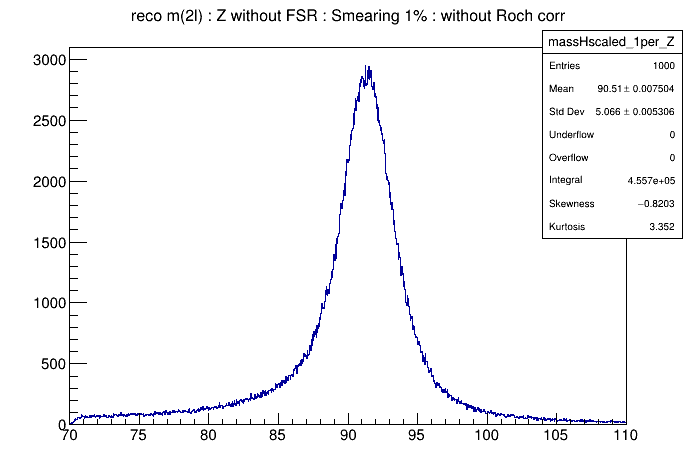

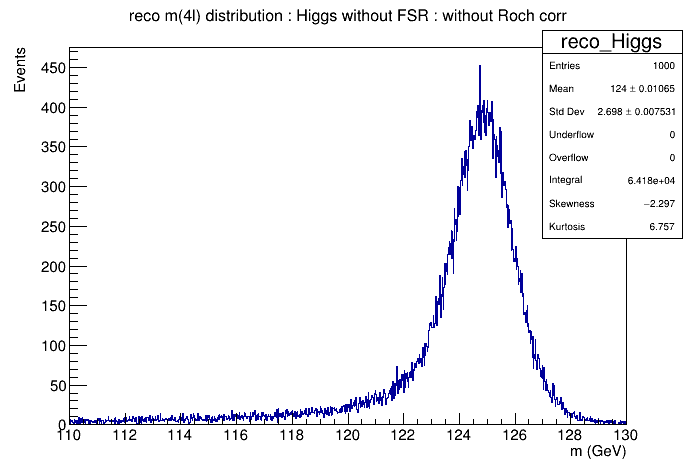

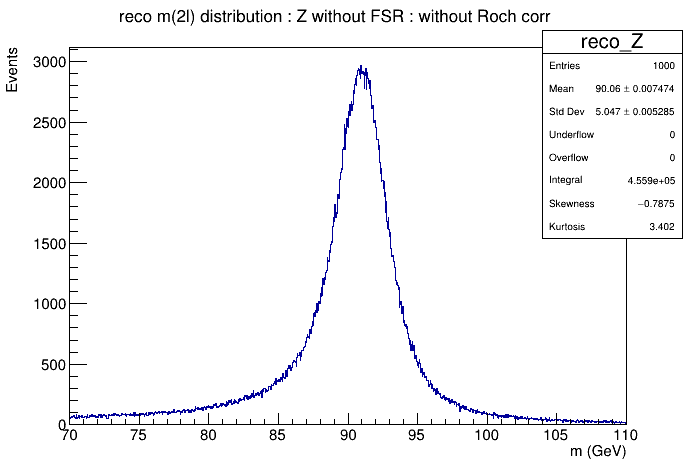

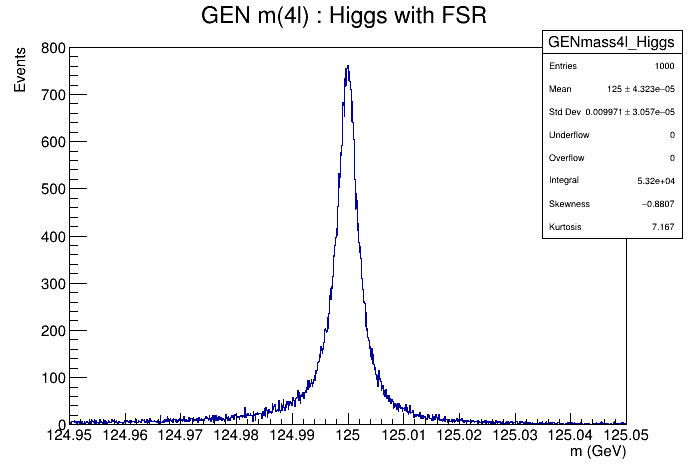

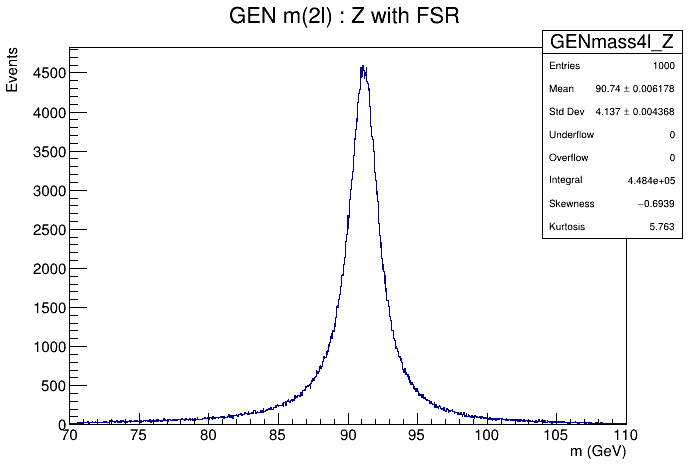

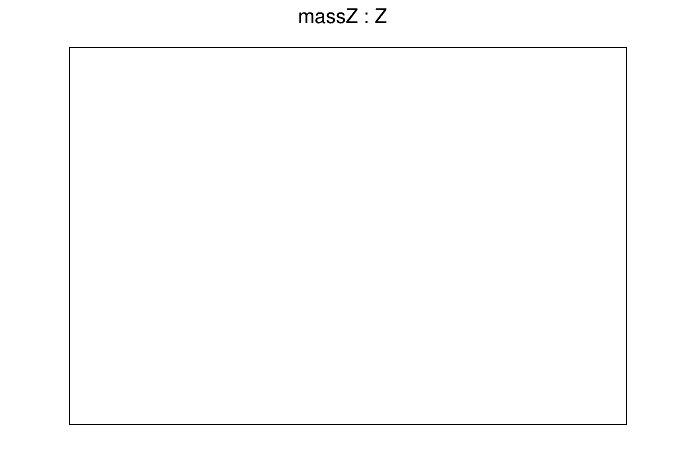

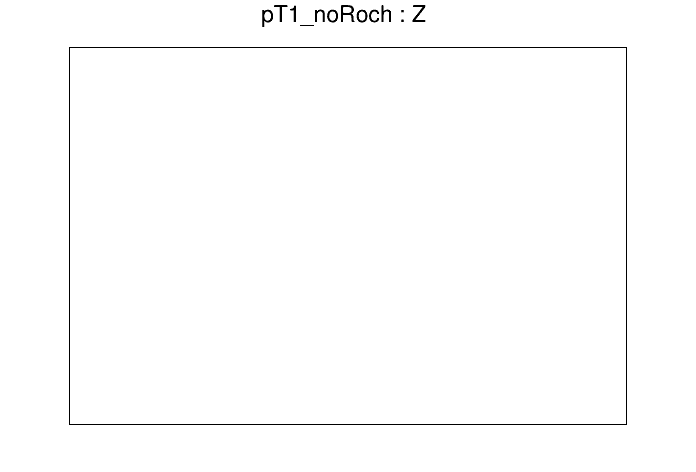

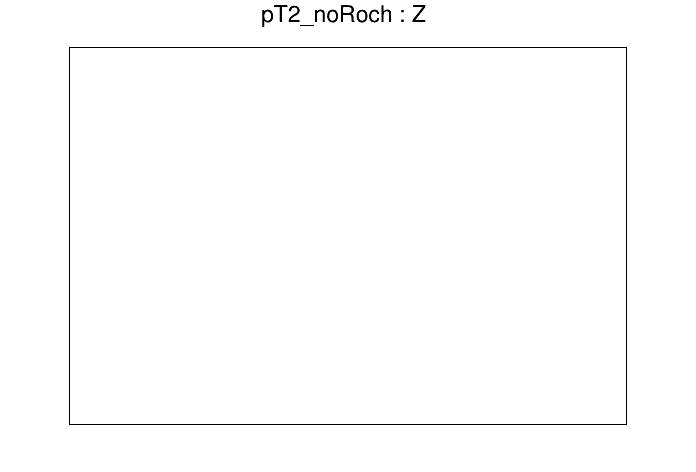

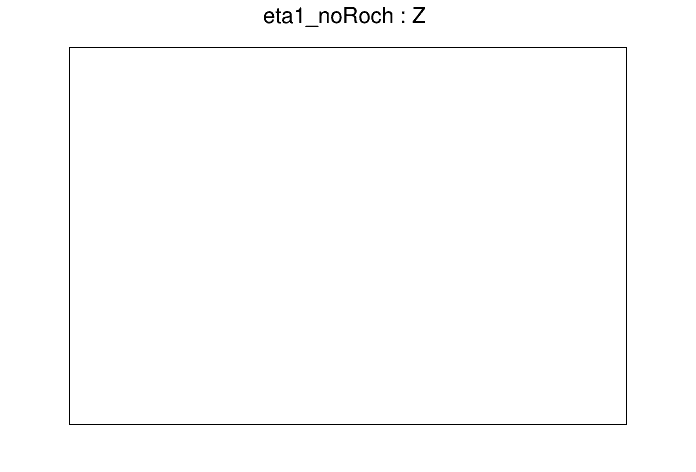

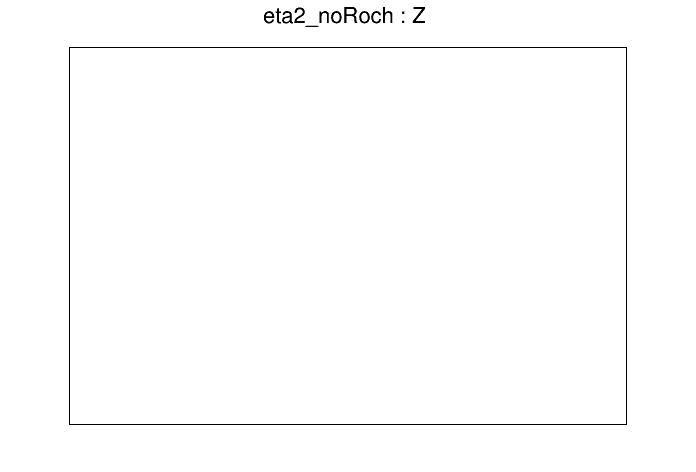

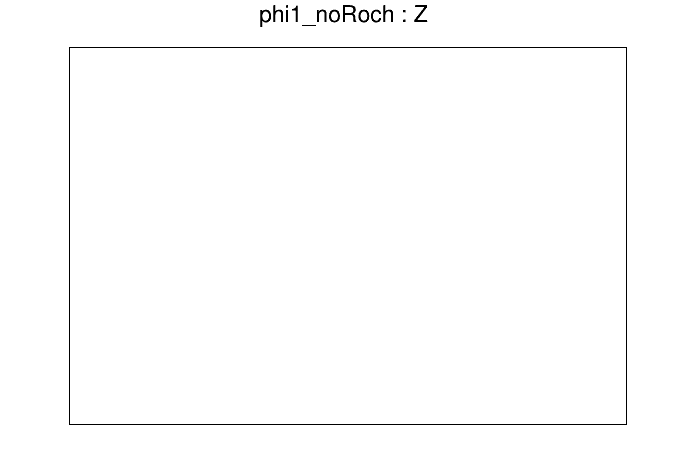

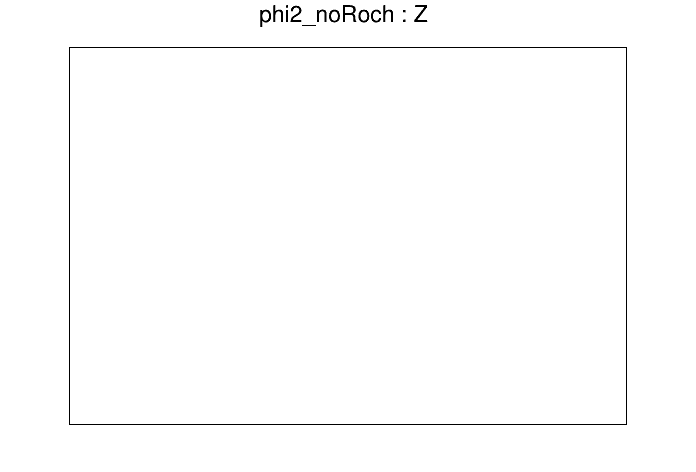

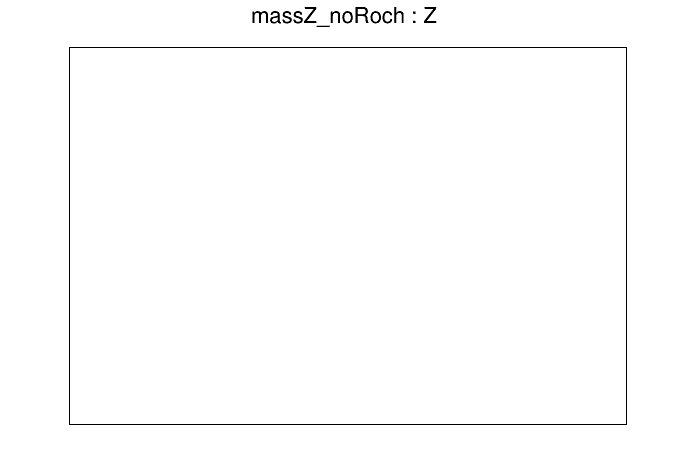

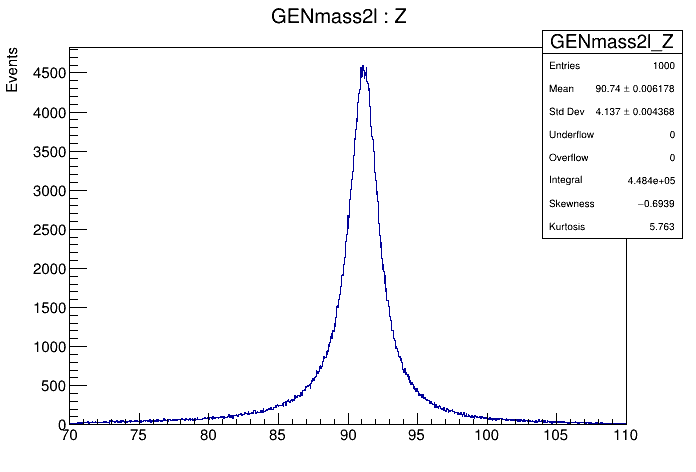

In [23]:
variables_new = ["pT1", "pT2", "eta1", "eta2", "phi1", "phi2", "massZ", "pT1_noRoch", "pT2_noRoch", "eta1_noRoch", "eta2_noRoch", "phi1_noRoch", "phi2_noRoch", "massZ_noRoch", "GENmass2l"]
for var in variables_new :
            if var == "massZ" or var == "massZ_noRoch" or var =="GENmass2l":
                var_range_file2 = mass_range_file2
                bins = bins_mass
            else:
                bins = bins_normal
                if "pT" in var:
                    var_range_file2 = pT_range
                elif "eta" in var:
                    var_range_file2 = eta_range
                elif "phi" in var:
                    var_range_file2 = phi_range
        
            hist2, edges2 = np.histogram(data2[var], bins, var_range_file2)
        
            bin_edges[var] = (hist2, edges2)
            th1d_hist2 = numpy_to_th1d(hist2, edges2, f"{var}_Z", 
                                          f"{var} : Z ")
            plot_hist_root_style(th1d_hist2, f"{var}_Z.pdf")
            th1d_hist2.GetYaxis().SetTitle("Events")
            th1d_hist2.SetTitle(f"{var} : Z")

In [24]:
var1 = "massH"
for scale_factor, scale_factor_string in zip(scale_factors, scale_factor_strings) : 
    scaled_massH1 = scale_pt_and_recalculate_mass_4l(data1, scale_factor)    
    scaled_hist1, scaled_edges1 = np.histogram(scaled_massH1, bins, mass_range_file1)

    plot_histogram(scaled_hist1, scaled_edges1, f"{var1}_{scale_factor_string}_mass_Higgs_scaled.png")
    scaled_th1d_hist1 = numpy_to_th1d(scaled_hist1, scaled_edges1, f"{var1}scaled_{scale_factor_string}per_Higgs", 
                                          f"reco m(4l) : Higgs without FSR : Smearing {scale_factor_string}% : {flag_str}")
    plot_hist_root_style(scaled_th1d_hist1, f"scaled_massH_{var1}_{scale_factor_string}_scaled.pdf")
    
    scaled_th1d_hist1.Write()


Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massH_massH_0_scaled.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massH_massH_0.03_scaled.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massH_massH_0.1_scaled.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massH_massH_0.3_scaled.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massH_massH_1_scaled.pdf has been created


In [25]:
if(flag=="Roch_corr"):
    var2 = "massZ"
elif(flag=="noRoch_corr"):
    var2 = "massZ_noRoch"
for scale_factor, scale_factor_string in zip(scale_factors, scale_factor_strings) : 
    print("scale factor", scale_factor)
    if(flag=="Roch_corr"):
        scaled_massH2 = scale_pt_and_recalculate_mass_2l_Roch(data2, scale_factor)
    elif(flag=="noRoch_corr"):
        scaled_massH2 = scale_pt_and_recalculate_mass_2l_noRoch(data2, scale_factor) 
    scaled_hist2, scaled_edges2 = np.histogram(scaled_massH2, bins, mass_range_file2)

    plot_histogram(scaled_hist2, scaled_edges2, f"{var2}_{scale_factor_string}_mass_Z_scaled.png")
    scaled_th1d_hist2 = numpy_to_th1d(scaled_hist2, scaled_edges2, f"massHscaled_{scale_factor_string}per_Z", 
                                          f"reco m(2l) : Z without FSR : Smearing {scale_factor_string}% : {flag_str}")
    plot_hist_root_style(scaled_th1d_hist2, f"scaled_massZ_{var2}_{scale_factor_string}_scaled.pdf")
    
    scaled_th1d_hist2.Write()

#scale_factor = 0 
#scaled_massH2 = scale_pt_and_recalculate_mass(data1, scale_factor)    
#scaled_hist2, scaled_edges2 = np.histogram(scaled_massH2, bins, mass_range_file1)
#plot_histogram(scaled_hist2, scaled_edges2, f"{var}_0_mass_Higgs_scaled.png")
#scaled_th1d_hist2 = numpy_to_th1d(scaled_hist2, scaled_edges2, f"{var}scaled_0_Higgs", 
#                                   f"reco m(4l) : Higgs without FSR : Smearing 0%")
#plot_hist_root_style(scaled_th1d_hist2, f"scaled_massH_{var}_0per_scaled.pdf")

scale factor 0
scale factor 0.0003
scale factor 0.001
scale factor 0.003
scale factor 0.01


Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massZ_massZ_noRoch_0_scaled.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massZ_massZ_noRoch_0.03_scaled.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massZ_massZ_noRoch_0.1_scaled.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massZ_massZ_noRoch_0.3_scaled.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/scaled_massZ_massZ_noRoch_1_scaled.pdf has been created


In [26]:
ROOT.gStyle.SetOptStat(111112211)
hist_mass1, edges_mass1 = create_histogram(data1["massH"], bins, mass_range_file1)
if(flag=="Roch_corr"):
    hist_mass2, edges_mass2 = create_histogram(data2["massZ"], bins, mass_range_file2)
elif(flag=="noRoch_corr"):
    hist_mass2, edges_mass2 = create_histogram(data2["massZ_noRoch"], bins, mass_range_file2)

mass_hist1, mass_edges1 = (hist_mass1, edges_mass1)
mass_hist2, mass_edges2 =(hist_mass2, edges_mass2)
    
th1d_mass_hist1 = numpy_to_th1d(mass_hist1, mass_edges1, f"reco_Higgs", f"reco m(4l) distribution : Higgs without FSR : {flag_str}")
th1d_mass_hist2 = numpy_to_th1d(mass_hist2, mass_edges2, f"reco_Z", f"reco m(2l) distribution : Z without FSR : {flag_str}")
    
th1d_mass_hist1.Write()
th1d_mass_hist2.Write()

hist_gen_mass1, edges_gen_mass1 = create_histogram(data1["GENmass4l"], bins, mass_gen_range_file1)
hist_gen_mass2, edges_gen_mass2 = create_histogram(data2["GENmass2l"], bins, mass_range_file2)
mass_gen_hist1, mass_gen_edges1 = hist_gen_mass1, edges_gen_mass1
mass_gen_hist2, mass_gen_edges2 = hist_gen_mass2, edges_gen_mass2 
    
th1d_gen_mass_hist1 = numpy_to_th1d(mass_gen_hist1, mass_gen_edges1,"GENmass4l_Higgs", "GEN m(4l) : Higgs with FSR ")
th1d_gen_mass_hist2 = numpy_to_th1d(mass_gen_hist2, mass_gen_edges2, "GENmass4l_Z", "GEN m(2l) : Z with FSR ")
    
th1d_gen_mass_hist1.Write()
th1d_gen_mass_hist2.Write()

#th1d_mass_hist1.SetTitle(f"reco m(4l) distribution : Higgs without FSR")
th1d_mass_hist1.GetYaxis().SetTitle("Events")
th1d_mass_hist1.GetXaxis().SetTitle("m (GeV)")
#th1d_mass_hist2.SetTitle(f"reco m(4l) distribution : Z without FSR")
th1d_mass_hist2.GetYaxis().SetTitle("Events")

th1d_mass_hist2.GetXaxis().SetTitle("m (GeV)")

#th1d_gen_mass_hist1.SetTitle(f"GEN m(4l) distribution : Higgs with FSR")
th1d_gen_mass_hist1.GetYaxis().SetTitle("Events")
th1d_gen_mass_hist1.GetXaxis().SetTitle("m (GeV)")
#th1d_gen_mass_hist2.SetTitle(f"GEN m(4l) distribution : Z with FSR")
th1d_gen_mass_hist2.GetYaxis().SetTitle("Events")
th1d_gen_mass_hist2.GetXaxis().SetTitle("m (GeV)")

plot_hist_root_style(th1d_mass_hist1, f"reco_massH_{scale_factor_string}.pdf")
plot_hist_root_style(th1d_mass_hist2, f"reco_massZ_{scale_factor_string}.pdf")
plot_hist_root_style(th1d_gen_mass_hist1, f"gen_massH_{scale_factor_string}.pdf")
plot_hist_root_style(th1d_gen_mass_hist2, f"gen_massZ_{scale_factor_string}.pdf")

Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/reco_massH_1.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/reco_massZ_1.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/gen_massH_1.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/gen_massZ_1.pdf has been created


In [27]:
def recalculate_gen_mass_4l(data):
    gen_massH = []
    for i in range(len(data["pT1_genFromReco"])):
        pT1, pT2, pT3, pT4 = data["pT1_genFromReco"][i], data["pT2_genFromReco"][i], data["pT3_genFromReco"][i], data["pT4_genFromReco"][i]
        eta1, eta2, eta3, eta4 = data["genLep_eta1"][i], data["genLep_eta2"][i], data["genLep_eta3"][i], data["genLep_eta4"][i]
        phi1, phi2, phi3, phi4 = data["genLep_phi1"][i], data["genLep_phi2"][i], data["genLep_phi3"][i], data["genLep_phi4"][i]
        mass = reconstruct_m4l(pT1, pT2, pT3, pT4, eta1, eta2, eta3, eta4, phi1, phi2, phi3, phi4)
        gen_massH.append(mass)
         
    mass_return = np.array(gen_massH)
    return mass_return

In [28]:
gen_massH = recalculate_gen_mass_4l(data1)  
gen_massZ = np.array(data2["genzm"])
hist_1, edges_1 = np.histogram(gen_massH, bins, mass_gen_range_file1)
hist_2, edges_2 = np.histogram(gen_massZ, bins, mass_gen_range_file2 )
plot_histogram(hist_1, edges_1, f"GENmass4l_withoutFSR_Higgs.png")
plot_histogram(hist_2, edges_2, f"GENmass4l_withoutFSR_Z.png")
th1d_hist_1 = numpy_to_th1d(hist_1, edges_1, f"GENmass4l_Higgs_without_FSR", f"GENmass4l without FSR : Higgs ")
plot_hist_root_style(th1d_hist_1, f"GENmass4l_Higgs_without_FSR.pdf")
th1d_hist_2 = numpy_to_th1d(hist_2, edges_2, f"GENmass4l_Z_without_FSR",f"GENmass4l without FSR : Z ")
plot_hist_root_style(th1d_hist_2, f"GENmass4l_Z_without_FSR.pdf")
            
th1d_hist_1.GetYaxis().SetTitle("Events")
th1d_hist_1.SetTitle(f"GENmass4l without FSR : Higgs")
th1d_hist_2.GetYaxis().SetTitle("Events")
th1d_hist_2.SetTitle(f"GENmass4l without FSR : Z")
th1d_hist_1.Write()
th1d_hist_2.Write()

6534

Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/GENmass4l_Higgs_without_FSR.pdf has been created
Info in <TCanvas::Print>: pdf file output_plots_2l_noRoch/eta_greater_1/GENmass4l_Z_without_FSR.pdf has been created


In [29]:
output_file.Close()

In [30]:
# Making the plot for pT, eta binning

In [31]:
def create_2d_histogram(data, x_var, y_var, x_bins, y_bins, x_range, y_range, title, output_path):
    hist, x_edges, y_edges = np.histogram2d(data[x_var], data[y_var], bins=[x_bins, y_bins], range=[x_range, y_range])
    plt.figure()
    plt.imshow(hist.T, origin='lower', aspect='auto', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    plt.colorbar(label='Number of entries')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(title)
    plt.savefig(output_path_dir+output_path)
    plt.close()


In [32]:
branches = ["pT1", "eta1", "pT2", "eta2"]


data2 = read_root_file(file2_path, branches)

y_bins = 50
x_bins = 50
y_range = (-2.5, 2.5)
x_range = (0, 200)

variables = [("pT1", "eta1"), ("pT2", "eta2")]

for x_var, y_var in variables:
    create_2d_histogram(data2, x_var, y_var, x_bins, y_bins, x_range, y_range,
                            f"{y_var} vs {x_var} : Z (2l)", f"{y_var}_vs_{x_var}_Z_2l.pdf")
